In [1]:
# Imports
from malab import *
from malab.datamanagement import SlabFile
from os.path import join
from glob import glob
from malab.dsfit import *
import os 
import datetime
from numpy import *
from tempfile import TemporaryFile

from matplotlib.pyplot import *
from scipy.signal import savgol_filter
import scipy.constants as constants

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

from malab.instruments.voltsource import *
from malab.instruments.instrumenttypes import *
from malab.instruments.PNAX import N5242A
from malab.dsfit import fithanger_new_withQc
from time import sleep
from copy import *


No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not load InstrumentManagerWindow


In [2]:
# DAC and YOKO setup

### YOKO setup
YOKO_4 = "192.168.1.77"
YOKO_2 = "192.168.1.57"
YOKO_5 = "192.168.1.141"

dcflux2 = YokogawaGS200(address=YOKO_5) # dc coil
dcflux2.recv_length = 1024
print(dcflux2.recv_length)
print(dcflux2.get_id())
print(dcflux2.get_id())
dcflux2.set_mode('current')
dcflux2.set_range(0.01)  # 10mA range
dcflux2.set_output(True)

### NWA (PNAX) setup
nwa = N5242A("N5242A", address="192.168.1.44", timeout=10e3) # pnax
print(nwa.get_id())

print('Deviced Connected')

# initial NWA configuration values
num_qubits = int(8)

# read_power = [-60, -65, -60, -60, -60, -60, -55, -55]
read_power = [-50]*num_qubits
read_freq_start = [6.11e9, 6.140e9, 6.16e9, 6.19e9, 6.215e9, 6.235e9, 6.272e9, 6.29e9]
read_freq_stop = [6.136e9, 6.16e9, 6.18e9, 6.215e9, 6.234e9, 6.252e9, 6.282e9, 6.312e9]

# drive_power = [-15, -15, -15, -15, -15, -20, -20, -20] # -40 w 20 attenuation
drive_power = [-30]*num_qubits
drive_freq_start = [3.2e9, 3.2e9, 3.2e9, 3.2e9, 3.2e9, 3.2e9, 3.2e9, 3.2e9]
drive_freq_stop = [5.7e9, 5.7e9, 5.7e9, 5.7e9, 5.7e9, 5.7e9, 5.7e9, 5.7e9]

# single tone
sweep_pts = 1001 #601
ifbw = [2000]*num_qubits
avgs = 3 #10

# two tone
sweep_pts2 = 2001  #1001 #501|
ifbw2 = [1000]*num_qubits
avgs2 = 10

delay = 0

### DACs setup
'''
labelled by flux lines
C5: Q0, C6: Q1, C7: Q2, C8: Q3
D1: Q4, D2: Q5, D3: Q6, D4: D4
'''
dac_C5toC8 = AD5780(address='192.168.1.66')
dac_D1toD4 = AD5780(address='192.168.1.156')
# dacs[qubit index][dac address or channel number]
dacs = [[dac_C5toC8, 1], [dac_C5toC8, 2],[dac_C5toC8, 3],[dac_C5toC8, 4],
        [dac_D1toD4, 1], [dac_D1toD4, 2],[dac_D1toD4, 3],[dac_D1toD4, 4]]
time.sleep(1)

#V/s or mA/s
dac_rate = 0.05

# converts DAC units to current value
def digit_to_curr(x):
    return 20*x/(2**18)-10

# initial offset of DAC channels, measured with volt meter
dac_offset = array([-0.002, -0.004, -0.003, -0.003, -0.004, -0.009, -0.02, -0.024])
diag_offset = dac_offset # set so background is zero, not needed here
#!!!! need to double check units here, w/o crosstalk matrix it should be V
flux_sweep = linspace(-0.1,0.1,11) # in unit not flux quantu, but V w/o correction

# numpts = [41]*num_qubits
# diag_offset = [0.0]*num_qubits
# diag_range = [1e-3]*num_qubits # yoko is in Ampere

# offdiag_range = diag_range
# offdiag_offset = diag_offset


1024
YOKOGAWA,GS210,90Z317691,2.02
YOKOGAWA,GS210,90Z317691,2.02
Keysight Technologies,N5242B,MY58422393,A.13.60.06

Deviced Connected


In [13]:
# Define useful functions
def drive_YOKO(pt):

    print("Driving YOKO at (%.3f) mA" % (pt[0]))
    dcflux2.ramp_current(pt[0]*1e-3, 0.0005) # second argument is rate?
    time.sleep(0.2)

def drive_DACs(pt):

    # I'm leaving this hardcoded for 8 qubits for now - Hebah 2024 12 16
    print("Driving DAC at ( %.3f, %.3f, %.3f, %.3f,%.3f, %.3f, %.3f, %.3f ) mA" %(pt[1], pt[2], pt[3], pt[4], pt[5], pt[6], pt[7], pt[8]))

    for ii in range(len(dacs)):
        print('\n')
        print('Flux line for qubit ', ii)
        print(dacs[ii][0])
        print("Driving DAC at (%.3f) mA" % (pt[ii+1]-dac_offset[ii]))
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dac_old = digit_to_curr(int(dacs[ii][0].get_voltage(dacs[ii][1])[:-2]))
        print('old reading = ', dac_old)
        dacs[ii][0].ramp(dacs[ii][1], pt[ii+1], dac_rate)
        time.sleep(1.5 * abs(dac_old - pt[ii+1]) / dac_rate + 5)
        time.sleep(5.0)
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])  # to clear the readout queue

def drive_DAC(pt, index):
    ii = index
    print('Driving DAC ' + str(index) + ' at ( %.3f ) mA' %(pt[ii+1]))

    
    print('\n')
    print('Flux line for qubit ', ii)
    print(dacs[ii][0])
    print("Driving DAC at (%.3f) mA" % (pt[ii+1]-dac_offset[ii]))
    dacs[ii][0].get_voltage(dacs[ii][1])
    dacs[ii][0].get_voltage(dacs[ii][1])
    dacs[ii][0].get_voltage(dacs[ii][1])
    dacs[ii][0].get_voltage(dacs[ii][1])
    dac_old = digit_to_curr(int(dacs[ii][0].get_voltage(dacs[ii][1])[:-2]))
    print('old reading = ', dac_old)
    dacs[ii][0].ramp(dacs[ii][1], pt[ii+1], dac_rate)
    time.sleep(1.5 * abs(dac_old - pt[ii+1]) / dac_rate + 5)
    time.sleep(5.0)
    dacs[ii][0].get_voltage(dacs[ii][1])
    dacs[ii][0].get_voltage(dacs[ii][1])
    dacs[ii][0].get_voltage(dacs[ii][1])
    dacs[ii][0].get_voltage(dacs[ii][1])  # to clear the readout queue

def drive_Yoko_and_DACs(pt):
    drive_YOKO(pt)
    drive_DACs(pt)


# pt_target = [dc coil, f0, f1, f2, f3, f4, f5, f6, f7]
def flux_msmt(pt_target, fname_tag, msmt_index=0):
    

    print("Configuring the PNAX")
    # turning off the pulses
    nwa.write("SENS:PULS0 0")  # automatically sync ADC to pulse gen
    nwa.write("SENS:PULS1 0")
    nwa.write("SENS:PULS2 0")
    nwa.write("SENS:PULS3 0")
    nwa.write("SENS:PULS4 0")
    # turning on the inverting
    nwa.write("SENS:PULS1:INV 1")
    nwa.write("SENS:PULS2:INV 1")
    nwa.write("SENS:PULS3:INV 1")
    nwa.write("SENS:PULS4:INV 1")

    nwa.set_timeout(10E3)
    nwa.clear_traces()
    nwa.setup_measurement("S21")
    # nwa.set_ifbw(ifbw[Res_index])
    # nwa.set_sweep_points(sweep_pts)
    # nwa.setup_take(averages_state=True)
    # nwa.set_averages_and_group_count(avgs, True)
    # print "PNAX Configured. IFBW = %f Hz, NumPts = %d, Avgs = %d " %(ifbw[Res_index],sweep_pts,avgs)

    dummy_freq = 5.0e9
    dummy_power = -50

    if isTakeData:

        vary_param = "flux"
        print("Swept Parameter: %s" % (vary_param))

        fname_list = []
        for jj in range(num_qubits):
            Qind = jj
            prefix = "flux_map-" + str(datetime.date.today()) + "_r" + str(Qind) + fname_tag

            fname = get_next_filename(expt_path, prefix, suffix='.h5')
            print(fname)
            fname = os.path.join(expt_path, fname)
            fname_list = np.append(fname_list,fname)



        print('\n\n')
        print('flux target =', pt_target)
        pt = (pt_target)
        print('No crosstalk matrix here!')
        print('flux actual =', pt)
        print('\n\n')

        if set_YOKO:
            drive_YOKO(pt)
        
        if set_DACs:
            drive_DACs(pt)

        print('\n\n')

        # sweep all qubits
        if measureAllQubits:
            for jj in range(num_qubits):

                Qind = jj

                with SlabFile(fname_list[jj], 'a') as f:
                    print("ISD:LJFJF")
                    print(nwa.get_settings())
                    f.save_settings(nwa.get_settings())

                print("Set up for a Single Tone Sweep")
                nwa.set_ifbw(ifbw[Qind])
                nwa.set_sweep_points(sweep_pts)
                nwa.setup_take(averages_state=True)
                nwa.set_averages_and_group_count(avgs, True)
                nwa.setup_two_tone_measurement(read_frequency=dummy_freq, read_power=read_power[Qind],
                                                probe_start=read_freq_start[Qind],
                                                probe_stop=read_freq_stop[Qind], probe_power=dummy_power,
                                                two_tone=0)

                data = nwa.take_one_in_mag_phase()

                fpoints = data[0]
                mags = data[1]
                phases = data[2]
                print("finished downloading")
                #time.sleep(na.get_query_sleep())

                freq_peak = fpoints[argmin(mags)]

                print("Set up for Two Tone Measurement, ReadFreq =", freq_peak)
                nwa.set_ifbw(ifbw2[Qind])
                nwa.set_sweep_points(sweep_pts2)
                nwa.setup_take(averages_state=True)
                nwa.set_averages_and_group_count(avgs2, True)
                nwa.setup_two_tone_measurement(read_frequency=freq_peak,
                                                read_power=read_power[Qind],
                                                probe_start=drive_freq_start[Qind],
                                                probe_stop=drive_freq_stop[Qind],
                                                probe_power=drive_power[Qind], two_tone=1)

                data = nwa.take_one_in_mag_phase()

                fpoints2 = data[0]
                mags2 = data[1]
                phases2 = data[2]
                print("finished downloading")
                print('\n')
                # time.sleep(na.get_query_sleep())

                #freq_peak_q = fpoints2[argmax(mags2)]
                #print "QubitFreq =", freq_peak_q

                with SlabFile(fname_list[Qind], 'a') as f:
                    f.append_pt((vary_param + 'dc_pts'), pt_target[0])
                    f.append_pt((vary_param + 'dc_actual_pts'), pt[0])
                    for ii in range(num_qubits):
                        f.append_pt((vary_param + str(ii) + '_pts'), pt_target[ii+1])
                        f.append_pt((vary_param + str(ii) + '_actual_pts'), pt[ii+1])
                    f.append_line('fpts-r', fpoints)
                    f.append_line('mags-r', mags)
                    f.append_line('phases-r', phases)
                    f.append_line('fpts-q', fpoints2)
                    f.append_line('mags-q', mags2)
                    f.append_line('phases-q', phases2)
                    # f.append_line('read_freq',read_freqs)
                    f.append_pt('read_power', read_power[Qind])
                    f.append_pt('probe_power', drive_power[Qind])
                    f.append_pt('read_freq', freq_peak)
        else: 
            jj = msmt_index
            Qind = jj

            with SlabFile(fname_list[jj], 'a') as f:
                print("ISD:LJFJF")
                print(nwa.get_settings())
                f.save_settings(nwa.get_settings())

            print("Set up for a Single Tone Sweep")
            nwa.set_ifbw(ifbw[Qind])
            nwa.set_sweep_points(sweep_pts)
            nwa.setup_take(averages_state=True)
            nwa.set_averages_and_group_count(avgs, True)
            nwa.setup_two_tone_measurement(read_frequency=dummy_freq, read_power=read_power[Qind],
                                            probe_start=read_freq_start[Qind],
                                            probe_stop=read_freq_stop[Qind], probe_power=dummy_power,
                                            two_tone=0)

            data = nwa.take_one_in_mag_phase()

            fpoints = data[0]
            mags = data[1]
            phases = data[2]
            print("finished downloading")
            #time.sleep(na.get_query_sleep())

            freq_peak = fpoints[argmin(mags)]

            print("Set up for Two Tone Measurement, ReadFreq =", freq_peak)
            nwa.set_ifbw(ifbw2[Qind])
            nwa.set_sweep_points(sweep_pts2)
            nwa.setup_take(averages_state=True)
            nwa.set_averages_and_group_count(avgs2, True)
            nwa.setup_two_tone_measurement(read_frequency=freq_peak,
                                            read_power=read_power[Qind],
                                            probe_start=drive_freq_start[Qind],
                                            probe_stop=drive_freq_stop[Qind],
                                            probe_power=drive_power[Qind], two_tone=1)

            data = nwa.take_one_in_mag_phase()

            fpoints2 = data[0]
            mags2 = data[1]
            phases2 = data[2]
            print("finished downloading")
            print('\n')
            # time.sleep(na.get_query_sleep())

            #freq_peak_q = fpoints2[argmax(mags2)]
            #print "QubitFreq =", freq_peak_q

            with SlabFile(fname_list[Qind], 'a') as f:
                f.append_pt((vary_param + 'dc_pts'), pt_target[0])
                f.append_pt((vary_param + 'dc_actual_pts'), pt[0])
                for ii in range(num_qubits):
                    f.append_pt((vary_param + str(ii) + '_pts'), pt_target[ii+1])
                    f.append_pt((vary_param + str(ii) + '_actual_pts'), pt[ii+1])
                f.append_line('fpts-r', fpoints)
                f.append_line('mags-r', mags)
                f.append_line('phases-r', phases)
                f.append_line('fpts-q', fpoints2)
                f.append_line('mags-q', mags2)
                f.append_line('phases-q', phases2)
                # f.append_line('read_freq',read_freqs)
                f.append_pt('read_power', read_power[Qind])
                f.append_pt('probe_power', drive_power[Qind])
                f.append_pt('read_freq', freq_peak)


        print(fname)

qubit_order = []
qubit_order.append(range(num_qubits))
qubit_order.append([4, 6, 1, 3, 5, 0, 7, 2])
qubit_order.append([5, 2, 7, 3, 0, 4, 1, 6])

print(qubit_order)
def plot_resonators(pt_target, filename_list, flux_index=0):

    figure(figsize=(20, 6), dpi=80)

    for ii,filename in enumerate(filename_list):
        # print(filename)
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 1000*10:  #in bytes
                with SlabFile(filename,'r') as a:
                    flux = array(a['flux'+str(flux_index)+'_pts'])
                    freq = array(a['fpts-'+'r'])[flux_index]
                    mags = array(a['mags-'+'r'])[flux_index]
                    
                    plot(freq/1e9,mags,color = 'C'+str(ii),label = 'Q'+str(qubit_order[1][ii])+': '+str(round(freq[np.argmin(mags)]/1e9,2)))
                    axvline(freq[np.argmin(mags)]/1e9, ls='--',color = 'C'+str(ii))
                    print("Resonator frequency for r"+str(ii)+": "+str(freq[np.argmin(mags)]/1e9))

    title("Resonators at " + str(pt_target))
    xlabel('Frequency (GHz)')
    ylabel('Power (dBm)')
    # reordering the labels 
    handles, labels = plt.gca().get_legend_handles_labels() 

    # specify order 
    order = [5, 2, 7, 3, 0, 4, 1, 6] 

    # pass handle & labels lists along with order as below 
    plt.legend([handles[i] for i in order], [labels[i] for i in order],bbox_to_anchor = (1.01,1),loc = 'upper left') 
    # legend(bbox_to_anchor = (1.04,0.5),loc = 'center left')

def plot_qubits(pt_target, filename_list, flux_index=0):

    figure(figsize=(20, 6), dpi=80)

    for ii,filename in enumerate(filename_list):
    # for filename in (filename_list[0][0]):
    #     ii=0
        # print(filename)
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 1000*10:  #in bytes
                with SlabFile(filename,'r') as a:
                    flux = array(a['flux'+str(flux_index)+'_pts'])
                    freq = array(a['fpts-'+'q'])[flux_index]
                    mags = array(a['mags-'+'q'])[flux_index]
                    
                    plot(freq/1e9,mags,color = 'C'+str(ii),label = 'Q'+str(qubit_order[1][ii])+': '+str(round(freq[np.argmax(mags)]/1e9,2)))
                    axvline(freq[np.argmax(mags)]/1e9, ls='--',color = 'C'+str(ii))
                    print("Qubit frequency for r"+str(ii)+": "+str(freq[np.argmax(mags)]/1e9))

    title("Qubits at " + str(pt_target))
    xlabel('Frequency (GHz)')
    ylabel('Power (dBm)')
    # reordering the labels 
    handles, labels = plt.gca().get_legend_handles_labels() 

    # specify order 
    order = [5, 2, 7, 3, 0, 4, 1, 6] 

    # pass handle & labels lists along with order as below 
    plt.legend([handles[i] for i in order], [labels[i] for i in order],bbox_to_anchor = (1.05,1),loc = 'upper left') 
    # legend(bbox_to_anchor = (1.04,0.5),loc = 'center left')

def plot_qubit(filename, qubit_index, flux_index=0):
    figure(figsize=(20, 6), dpi=80)

    # for filename in (filename_list[0][0]):
    #     ii=0
        # print(filename)

    ii = qubit_index

    if os.path.isfile(filename):
        if os.path.getsize(filename) > 1000*10:  #in bytes
            with SlabFile(filename,'r') as a:
                flux = array(a['flux'+str(flux_index)+'_pts'])
                freq = array(a['fpts-'+'q'])[flux_index]
                mags = array(a['mags-'+'q'])[flux_index]
                
                plot(freq/1e9,mags,color = 'C'+str(ii),label = 'Q'+str(qubit_order[1][ii])+': '+str(round(freq[np.argmax(mags)]/1e9,2)))
                axvline(freq[np.argmax(mags)]/1e9, ls='--',color = 'C'+str(ii))
                print("Qubit frequency for r"+str(ii)+": "+str(freq[np.argmax(mags)]/1e9))

    # title("Qubits at " + str(pt_target))
    xlabel('Frequency (GHz)')
    ylabel('Power (dBm)')
    legend()

[range(0, 8), [4, 6, 1, 3, 5, 0, 7, 2], [5, 2, 7, 3, 0, 4, 1, 6]]


In [9]:
expt_path = "M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test"
fname_tag = "test"

isTakeData = 1
set_YOKO = 0
set_DACs = 0
measureAllQubits = 1

pt = [0, 0, 0, 0, 0, 0, 0, 0, 0]
flux_msmt(pt, fname_tag)

Configuring the PNAX
Swept Parameter: flux
00002_flux_map-2025-01-25_r0test.h5
00001_flux_map-2025-01-25_r1test.h5
00001_flux_map-2025-01-25_r2test.h5
00001_flux_map-2025-01-25_r3test.h5
00001_flux_map-2025-01-25_r4test.h5
00001_flux_map-2025-01-25_r5test.h5
00001_flux_map-2025-01-25_r6test.h5
00001_flux_map-2025-01-25_r7test.h5



flux target = [0, 0, 0, 0, 0, 0, 0, 0, 0]
No crosstalk matrix here!
flux actual = [0, 0, 0, 0, 0, 0, 0, 0, 0]






ISD:LJFJF
{'start': 3200000000.0, 'stop': 5700000000.0, 'power': -50.0, 'ifbw': 1000.0, 'sweep_points': 2001, 'averaging': True, 'averages': 10}
Set up for a Single Tone Sweep
TWO TONE OFF
Turning off the port 3
finished downloading
Set up for Two Tone Measurement, ReadFreq = 6129786000.0
TWO TONE ON
finished downloading


ISD:LJFJF
{'start': 3200000000.0, 'stop': 5700000000.0, 'power': -50.0, 'ifbw': 1000.0, 'sweep_points': 2001, 'averaging': True, 'averages': 10}
Set up for a Single Tone Sweep
TWO TONE OFF
Turning off the port 3
finished down

['M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00002_flux_map-2025-01-25_r0test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r1test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r2test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r3test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r4test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r5test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r6test.h5', 'M:/malab/_Data/20250120 - Santi - RFSoC tprocv2 - LL8qubit T1/data/test\\00001_flux_map-2025-01-25_r7test.h5']
Resonator frequency for r0: 6.129786
Resonator frequency for r1: 6.1527
Resonator frequency for r2: 6.1

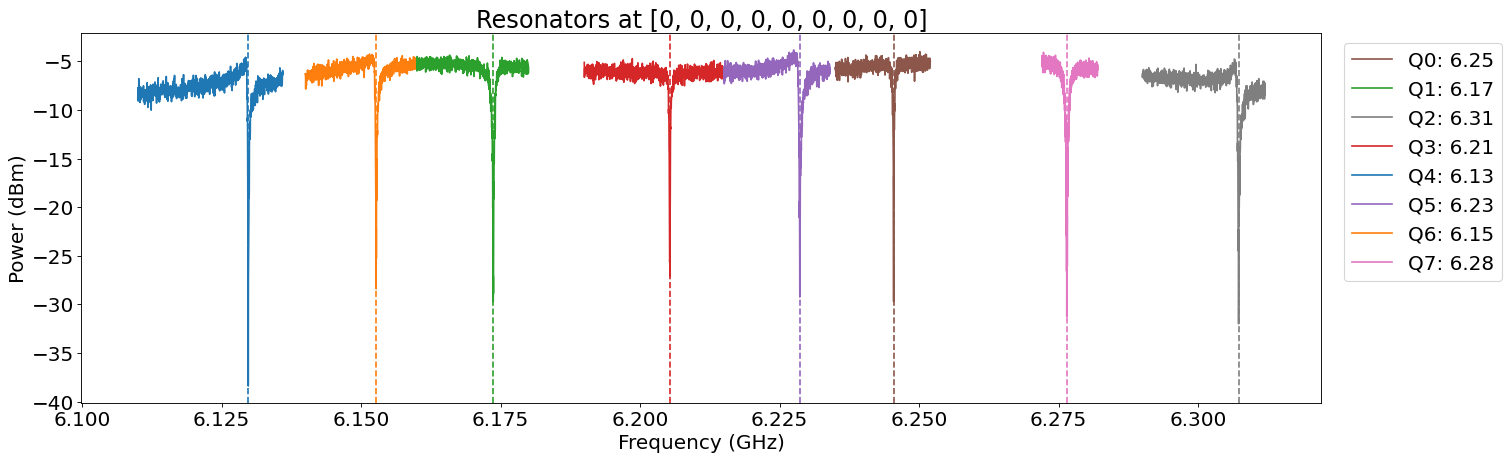

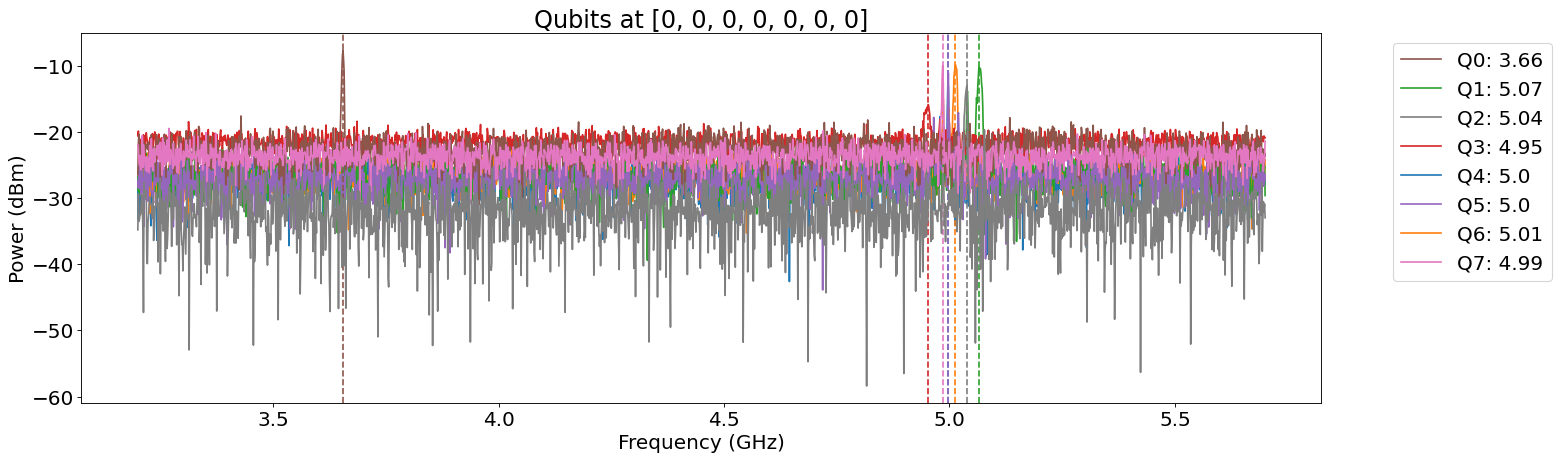

In [15]:
filename_list = []
for q in range(num_qubits):
    if q == 0:
        filename_list.append(expt_path+r'\00002_flux_map-2025-01-25_r'+str(q)+fname_tag+'.h5')
    else:
        filename_list.append(expt_path+r'\00001_flux_map-2025-01-25_r'+str(q)+fname_tag+'.h5')
print(filename_list)

plot_resonators(pt, filename_list)
# xlim(6.12,6.13)
plot_qubits(pt[0:7], filename_list)
# xlim(3.72, 3.75)

In [ ]:
def check_YOKO():
    
def check_DACs():
    dac_readings = []
    for ii in range(len(dacs)):
        # print('\n')
        # print('Flux line for qubit ', ii)
        print(dacs[ii][0])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dacs[ii][0].get_voltage(dacs[ii][1])
        dac_old = digit_to_curr(int(dacs[ii][0].get_voltage(dacs[ii][1])[:-2]))
        # print('current reading = ', dac_old)
        dac_readings.append(dac_old)
    print(dac_readings)

check_DACs()

[-8.391036987304688, 2.07916259765625, 1.501312255859375, -0.9397125244140625, -1.23931884765625, -1.46087646484375, -1.3837432861328125, -2.23114013671875]
